In [1]:
import os
import sys
import yaml
import hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from datetime import datetime

sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('..\posts_feed_service\lib')))

from posts_feed_service.lib.datatypes import FeedResponse, PostGet
from posts_feed_service.lib.utils import get_group, request_transform

In [2]:
# Прочтём файл конфига с путями

CONFIG_PATH = "config.yaml"
with open(CONFIG_PATH, "r", encoding="utf-8") as config_file:
    CONFIG = yaml.load(config_file, Loader=yaml.FullLoader)

## Обработка датасета

In [27]:
# Загрузим выгруженный ранее из базы данных записи действий пользователей
# за последние две недели наблюдений - на основе них будем проводить анализ

test_df = pd.read_csv(CONFIG['data_folder'] + '/test_data.csv')
test_df.head()

,timestamp,user_id,post_id,action,target
0,2021-12-28 16:54:11,93131,1085,view,1
1,2021-12-28 23:04:25,139522,3516,view,1
2,2021-12-16 12:38:03,82300,3820,view,1
3,2021-12-29 12:32:00,29208,1784,view,1
4,2021-12-18 21:20:53,66754,1335,view,1


In [28]:
test_df.shape

(1444810, 5)

In [29]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444810 entries, 0 to 1444809
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   timestamp  1444810 non-null  object
 1   user_id    1444810 non-null  int64 
 2   post_id    1444810 non-null  int64 
 3   action     1444810 non-null  object
 4   target     1444810 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 55.1+ MB


In [30]:
test_df['request_time'] = pd.to_datetime(test_df.timestamp)
test_df = test_df.drop(['timestamp'], axis=1)

<AxesSubplot:>

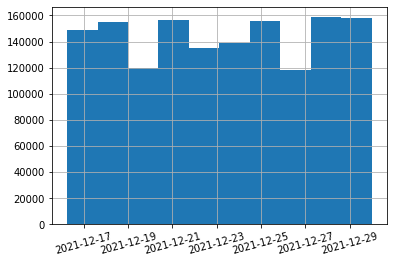

In [31]:
test_df.request_time.hist(xrot=15)

Преобразуем датасет в "тестовые" для дальнейшего анализа.

Получим сперва отклики нашего сервиса с лентой для каждого действия пользователя и затем проанализируем.

### Ответы сервиса с рекомендациями

In [8]:
# Класс модели нашей рекомендационной системы

class Model:
    """
    Класс Model для получения ленты новостей
    """
    def __init__(self):
        """
        Конструктор класса Model

        Загружает всё необходимое для обработки
        признаков и получения ленты.
        """
        self.control_model = CatBoostClassifier()
        self.test_model = CatBoostClassifier()

        self.control_model.load_model(CONFIG["classic_ml_model"])
        self.test_model.load_model(CONFIG["text_emb_model"])

        self.models_dict = {
            "control": self.control_model,
            "test": self.test_model
        }

        self.tables = {
            "posts": pd.read_csv(CONFIG["post_df"]),
            "users": pd.read_csv(CONFIG["user_df"]),
            "posts_tfidf": pd.read_csv(CONFIG["tfidf_df"]),
            "posts_lemmatized": pd.read_csv(CONFIG["lemmatized_post_df"]),
            "embs_post_df": pd.read_csv(CONFIG["embs_post_df"])
        }

    def get_feed(self, request: dict) -> FeedResponse:
        """
        Метод получения предсказания цены автомобиля.

        Производит обработку признаков запроса и
        получает рекомендованные новости.
        """
        exp_group = get_group(request["user_id"])
        posts_limit = request.get("posts_limit", 5)
        request = request_transform(request, exp_group, self.tables)

        request_model = self.models_dict[exp_group]
        col_order = request_model.feature_names_
        feed_prediction = request_model.predict_proba(request[col_order])[:, 1]

        indices = np.argpartition(
            feed_prediction,
            -posts_limit
        )[-posts_limit:]
        result_feed = self.tables["posts"].iloc[indices].reset_index()

        recs = FeedResponse()
        recs.exp_group = exp_group
        for i, post in result_feed.iterrows():
            recs.feed.append(
                PostGet(
                    post_id=post["post_id"],
                    text=post["text"],
                    topic=post["topic"]
                )
            )
        return recs

In [23]:
# Напишем функцию получения рекомендаций по нашему датасету

def get_recs_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция обработки датасета логов пользователей.
    
    По user_id и времени запроса добавляет к датасету
    колонки с группой пользователя и лентой, которую даёт наш сервис.
    """
    model = Model()
    start = time.time()
    df['exp_group'] = df.user_id.apply(lambda x: get_group(x))
    group = time.time()
    df['recommendations'] = df.apply(lambda x: [post.post_id for post in model.get_feed(x).feed], axis=1)
    end = time.time()
    print(group - start)
    print(end - group)
    return df


In [ ]:
test_df = get_recs_df(test_df)

test_df.head()

In [ ]:
test_df.shape

In [ ]:
test_df.info()

In [ ]:
test_df.to_csv(CONFIG['datasets_folder'] + '/test_data_with_recs.csv', index=False)

In [59]:
import time

start = time.time()
get_recs_df(test_df.sample(1))
end = time.time()

end - start

0.0
0.022825002670288086


0.7386033535003662

In [60]:
test_df.shape

(1444810, 6)

In [ ]:
test_df.info()